# Deep dive

In [1]:
from bhad import model, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

In [88]:
grid = np.linspace(-4,4,100)

# Draw a sample via Accept/Reject sampling:
#-------------------------------------------
y = utils.rbartsim(MCsim = 1*10**5, seed = None, verbose = True)

Acceptance rate: 0.46306



In [89]:
from scipy.integrate import simpson

gamma_grid = np.linspace(1e-4,1-1e-4, 30)

# Square root choice:
h_sq = np.ceil(np.sqrt(N))
prior_max_M = min(int(0.3*N), int(h_sq))
print(prior_max_M)   # https://en.wikipedia.org/wiki/Histogram


log_marg_prior_nbins = {}
for m in range(1, prior_max_M, 1):
    
    prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

    area = simpson(utils.exp_normalize(prior), gamma_grid)
    #area = simpson(prior, gamma_grid)
    
    log_marg_prior_nbins[m] = np.log(1e-10 + area)

log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}
#log_marg_post = {m : utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}   # uniform prior

# Compute K_MAP for each feature:
#---------------------------------
opt_M = max(log_marg_post, key=log_marg_post.get)
print(opt_M)

post = utils.exp_normalize(np.array(list(log_marg_post.values())))
lpost = list(log_marg_post.values())
xx = np.array(list(log_marg_post.keys()))

#-----------------------------
# Credible interval of number of bins:
#-------------------------------
sig_level = 0.05
upper = np.sum(np.cumsum(post) <= (1-(sig_level/2))) + 1
lower = np.sum(np.cumsum(post) <= sig_level/2) + 1
median = np.sum(np.cumsum(post) <= 0.5) + 1

#opt_M = np.argmax(post) + 1

#print(opt_M)
print((lower, median, upper))


682
116
(116, 116, 116)


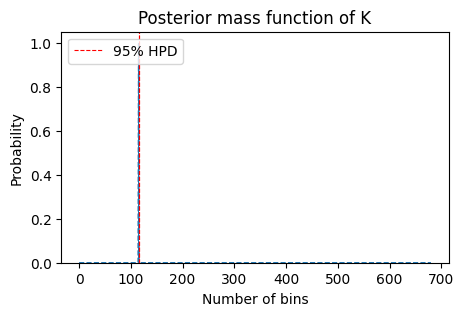

In [90]:
fig = plt.figure(figsize=(5,3))
ax = plt.axes()

s = xx - 1
#s = xx[(xx > 20) & (xx < 80)] 

#ax.plot(xx, post)
ax.plot(s, post[s], '--', linewidth=1)
#ax.bar(s, post)
ax.bar(s, post[s])
#ax.scatter(s, pr)
ax.axvline(x = lower, color = 'red',linestyle = '--', linewidth=0.8, label = f'{int((1-sig_level)*100)}% HPD')
ax.axvline(x = upper, color = 'red',linestyle = '--', linewidth=0.8)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Probability')
ax.legend(loc="upper left")
ax.set_title('Posterior mass function of K')
#fig.savefig('post_k.png')   # save the figure to file
plt.show();
#plt.close(fig)    # close the figure window

In [91]:
from scipy.stats import iqr
from astropy.stats import scott_bin_width, knuth_bin_width, freedman_bin_width, bayesian_blocks

N = len(y)

print(f'\nMAP number of bins: {opt_M}')

# Freedman-Diaconis rule:
bw = 2*iqr(y)*N**(-1/3)
FD = (max(y) - min(y))/bw
opt_fd = int(FD)
print(f'Freedman-Diaconis rule: {opt_fd}')

# Sturges:
opt_sturges = int(1 + 3.322*np.log(N))
print(f'Sturges rule: {opt_sturges}')

# Scott's normal reference rule:
#h = (3.49*np.std(y))/(N)**(1/3)     # bin width
h_scott = scott_bin_width(y)
opt_scott = int((max(y)-min(y))/h_scott)
print(f"Scotts rule: {opt_scott}")         # https://en.wikipedia.org/wiki/Histogram

# Square root choice:
#h_sq = np.ceil(np.sqrt(N))
#opt_sq = int(h_sq)
#print(int(h_sq))


# MAP with uniform prior on nbins:
h_knuth = knuth_bin_width(y)
opt_knuth = int((max(y)-min(y))/h_knuth)
#print(f"Knuths rule: {opt_knuth}")         # https://arxiv.org/pdf/physics/0605197.pdf



MAP number of bins: 116
Freedman-Diaconis rule: 110
Sturges rule: 36
Scotts rule: 88


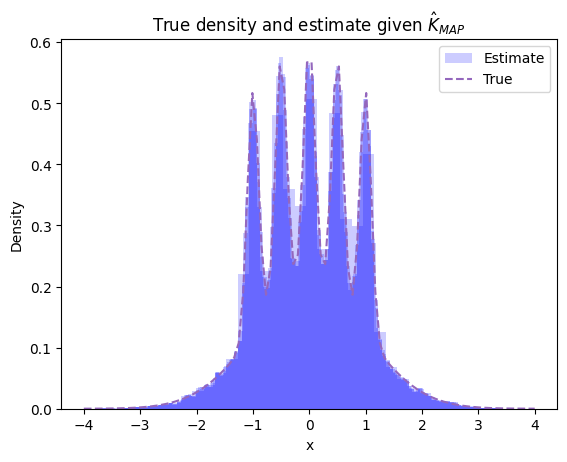

In [92]:
y_true = utils.bart_simpson_density(grid)

fig = plt.figure()

# create the histogram
counts1, bins1, patches1 = plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
counts2, bins2, patches2 = plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2); main = 'Freedman-Diaconis'
counts3, bins3, patches3 = plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2); main = 'Sturges'
counts4, bins4, patches4 = plt.hist(y, bins=opt_scott + 1, density=True, facecolor='b', alpha=0.2); main = 'Scott'

plt.plot(grid, y_true, linestyle='dashed', label='True')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title(r'True density and estimate given $\hat{K}_{MAP}$ ')    #  with Bayes estimate number of bins
#fig.savefig(f'est_Bart_{main}.png')   # save the figure to file

plt.show();
#plt.close(fig)    # close the figure window

In [93]:

ord1, ord2, ord3, ord4 = [], [], [], []
for x in grid:
    
    if np.any(bins1 <= x):
        bucket_index1 = np.max(np.where(bins1 <= x))
        ord1.append(counts1[bucket_index1-1])
    else:
        ord1.append(counts1[0])

    if np.any(bins2 <= x):
        bucket_index2 = np.max(np.where(bins2 <= x))
        ord2.append(counts2[bucket_index2-1])
    else:
        ord2.append(counts2[0])

    if np.any(bins3 <= x):
        bucket_index3 = np.max(np.where(bins3 <= x))
        ord3.append(counts3[bucket_index3-1])
    else:
        ord3.append(counts3[0])
        
    if np.any(bins4 <= x):
        bucket_index4 = np.max(np.where(bins4 <= x))
        ord4.append(counts4[bucket_index4-1])
    else:
        ord4.append(counts4[0])

        
df = pd.DataFrame()
df['x'] = grid
#df['ytrue'] = y_true
df['mse1'] = (y_true-ord1)**2    # Bayes
df['mse2'] = (y_true-ord2)**2    # Freedman
df['mse3'] = (y_true-ord3)**2    # Sturges
df['mse4'] = (y_true-ord4)**2    # Scott

np.round(np.mean(df.values, axis=0)[1:],5)        

array([0.00318, 0.00342, 0.01472, 0.00605])